# Equação de Tolman-Oppenheimer-Volkoff (TOV)

Partimos da métrica de Swarzschild (trabalhamos com unidades onde $c = G = 1$):

$$ds^2 =  -\left( 1 - \frac{2M}{r} \right) dt^2 + {\left( 1 - \frac{2M}{r} \right)}^{-1} dr^2 + r^2 d\theta^2 + r^2 \sin^2 \theta d\phi^2$$

e do tensor de energia momentum para um fluido perfeito:

$$T^{\mu \nu} = (\rho + p)U^{\mu} U^{\nu} + p g^{\mu \nu} $$

As equações de campo de Einsten nos dão a relação entre a métrica e o tensor de energia momentum:

$$R_{\mu \nu} - \frac{1}{2} R g_{\mu \nu} = 8 \pi T_{\mu \nu}$$

Com isso podemos igualar ambas essas grandezas e, após um pouco de álgebra, chegamos a:

$$\frac{dp}{dr} = -\frac{m(r) \epsilon (r)}{r^2} \left[ 1 - \frac{p(r)}{\epsilon(r)} \right] \left[ 1 + \frac{4 \pi r^3 p(r)}{m(r)} \right] {\left[ 1 - \frac{2m(r)}{r} \right]}^{-1}$$
$$\frac{dm}{dr} = 4 \pi r^2 \epsilon(r)$$


São duas equações diferenciais acopladas, que, com as condições de que a massa no centro seja $m(0) = 0$ e que a pressão na superfície seja $p(r = R) = 0$ onde $R$ ficará definido como o raio da estrela e $m(r = R) = M$ é a massa total da estrela (massa gravitacional). Ainda precisamos de uma condição inicial na pressão que será $p(0) = p_0$, essa condição porém será arbitrária. *Estrelas com $p_0$ diferente terão valores de massa ($M$) e raio ($R$) diferentes*. Ainda nos falta uma informação, que é $\epsilon(r)$.

# Equação de estado

É a equação de estado que nos diz sobre como a matéria da estrela é constituida e como ela interage. Com uma equação de estado podemos encontrar uma relação entre $p(r)$ e $\epsilon(r)$ e finalmente resolvermos o sistema. A equação de estado mais simples que existe é a equação de estado politrópica onte temos:

$$p = K\epsilon^{\gamma}$$

onde $K$ é uma constante e $\gamma$ um índice politrópico (não lembro ao certo se o $\gamma$ é o índice politrópico). Porém, essa equação de estado simplesmente considera a estrela como uma bola de gás e podemos achar bem difícil e não tão agradável trabalhar com equações de estado politrópicas.

# Resolvendo a TOV

Por termos muitas constantes e grandezas físicas com ordens de grandezas muito diferentes, podemos encontrar problemas numéricos ao tentarmos resolver. Para evitar tais problemas vamos trabalhar com um sistema de unidades onde $c = G = M_{\odot} = 1$ onde $c$ é a velocidade da luz, $G$ é a constante de Newton e $M_{\odot}$ é a massa do Sol (veremos mais tarde por quê é interessante fazermos ela igual a 1 também). Após um desenvolvimento com unidades (presente em outro notebook nesse repositório) encontramos os fatores de conversão das unidades de comprimento, massa e tempo do SI para esse sistema definido.

$$\text{unidade de massa} = M_{\odot} = 1.989 \times 10^{30} kg$$
$$\text{unidade de distancia} = \frac{G M_{\odot}}{c^2} = 1.477 \times 10^3 m$$
$$\text{unidade de tempo} = \frac{G M_{\odot}}{c^3} = 4.927 \times 10^{-6}s$$

O motivo para termos definido a massa do Sol como 1 será para obtermos as massas sempre em massas solares (que vai ser muito útil pois estamos resolvendo uma equação para a massa de uma estrela).

Sabendo esses fatores de conversão podemos facilmente converter todas as grandezas (como aquelas da equação de estado) para esse sistema de unidades. Todo esse trabalho com unidades será localizado em um arquivo com todas as constantes necessárias e fatores de conversão: `constants.jl`. 

Vamos agora incluir os arquivos necessários para resolvermos a TOV aqui:

In [1]:
include("constants.jl")
include("diff.jl")

solve_system

Vamos definir uma função para a equação de estado:

In [2]:
using Interpolations
using CSV
using DataFrames
using Plots

In [3]:
# As vezes podemos receber umas equações de estado não monotonicas
function remove_negative_slopes(eos)
    new_eos = DataFrame()
    new_eos.P = Vector{Float64}()
    new_eos.e = Vector{Float64}()

    highest = 0.0
    for (p_i, ϵ_i) in zip(eos.P, eos.e)
        if p_i > highest
            highest = p_i
            push!(new_eos.P, p_i)
            push!(new_eos.e, ϵ_i)
        end
    end
    
    return new_eos
end

eosdata = CSV.File("eos.csv") |> DataFrame
eosdata = remove_negative_slopes(eosdata)

p_pu = eosdata.P .* ((1e3)^4 * mev4_to_mevfm3 * MeVfm3)
ϵ_pu = eosdata.e .* ((1e3)^4 * mev4_to_mevfm3 * MeVfm3)

eos_interp = linear_interpolation(p_pu, ϵ_pu, extrapolation_bc=Line()) 
eos(p) = eos_interp(p)

eos (generic function with 1 method)

In [4]:
pressure_eq(r, p, m) = -(m*eos(p)/r^2)*(1 + p/eos(p))*(1 + 4π*r^3*p/m)*(1 - 2m/r)^(-1)
mass_eq(r, p, m) = 4π*r^(2)*eos(p)

f(t, u) = [pressure_eq(t, u[1], u[2]), mass_eq(t, u[1], u[2])]
condition(t, u, i) = u[1] <= 0 || i > 100_000 ? false : true

r0 = 1e-8
m0 = 1e-24

1.0e-24

In [11]:
p0 = 100MeVfm3
sol = solve_system(f, r0, [p0, m0], 1m, condition)
sol

9022×3 Matrix{Float64}:
 1.0e-8        0.000288692  1.0e-24
 0.000677182   0.000288692  2.45616e-12
 0.00135435    0.000288692  1.96488e-11
 0.00203153    0.000288692  6.63143e-11
 0.0027087     0.000288692  1.57189e-10
 0.00338587    0.000288692  3.07009e-10
 0.00406304    0.000288692  5.30511e-10
 0.00474022    0.000288692  8.4243e-10
 0.00541739    0.000288692  1.2575e-9
 0.00609456    0.000288692  1.79047e-9
 0.00677173    0.000288692  2.45606e-9
 0.0074489     0.000288691  3.26901e-9
 0.00812608    0.000288691  4.24407e-9
 ⋮                          
 6.10132       3.99735e-7   1.21942
 6.102         3.62654e-7   1.21974
 6.10268       3.25576e-7   1.22006
 6.10335       2.88503e-7   1.22037
 6.10403       2.51433e-7   1.22069
 6.10471       2.14367e-7   1.22101
 6.10539       1.77305e-7   1.22133
 6.10606       1.40246e-7   1.22164
 6.10674       1.03192e-7   1.22196
 6.10742       6.61404e-8   1.22228
 6.10809       2.90929e-8   1.2226
 6.10877      -7.9508e-9    1.22292

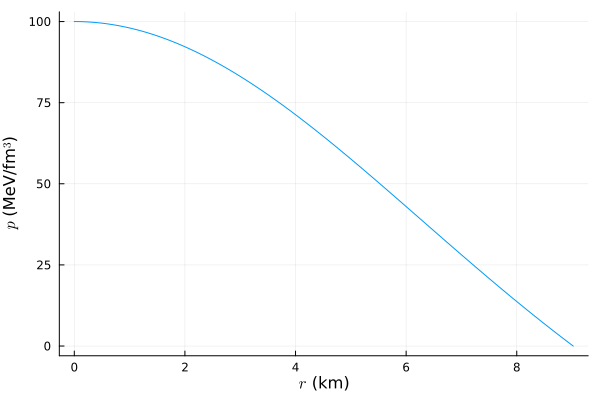

In [13]:
plot(sol[:, 1] .* (lu*1e-3), sol[:, 2] .* pu_to_mevfm3, label=false, 
    xaxis=raw"$r$ (km)", yaxis=raw"$p$ (MeV/fm$^3$)")

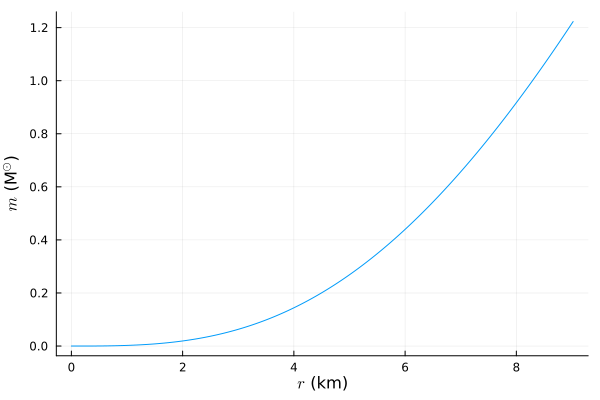

In [14]:
plot(sol[:, 1] .* (lu*1e-3), sol[:, 3], label=false, xaxis=raw"$r$ (km)", 
    yaxis=raw"$m$ (M$^{\odot}$)")

Agora vamos resolver para $p_0 = 200 \text{MeV}/{\text{fm}^3}$

In [15]:
p0 = 200MeVfm3
sol = solve_system(f, r0, [p0, m0], 1m, condition)
sol

9230×3 Matrix{Float64}:
 1.0e-8        0.000577384  1.0e-24
 0.000677182   0.000577384  3.60351e-12
 0.00135435    0.000577384  2.88275e-11
 0.00203153    0.000577384  9.7292e-11
 0.0027087     0.000577384  2.30617e-10
 0.00338587    0.000577384  4.50423e-10
 0.00406304    0.000577384  7.7833e-10
 0.00474022    0.000577384  1.23596e-9
 0.00541739    0.000577383  1.84493e-9
 0.00609456    0.000577383  2.62686e-9
 0.00677173    0.000577383  3.60337e-9
 0.0074489     0.000577383  4.79608e-9
 0.00812608    0.000577382  6.22661e-9
 ⋮                          
 6.24217       5.45034e-7   1.50343
 6.24285       4.94413e-7   1.50376
 6.24353       4.43802e-7   1.50409
 6.24421       3.93201e-7   1.50442
 6.24488       3.4261e-7    1.50476
 6.24556       2.92029e-7   1.50509
 6.24624       2.41458e-7   1.50542
 6.24691       1.90897e-7   1.50575
 6.24759       1.40347e-7   1.50609
 6.24827       8.98065e-8   1.50642
 6.24895       3.92763e-8   1.50675
 6.24962      -1.12438e-8   1.50708

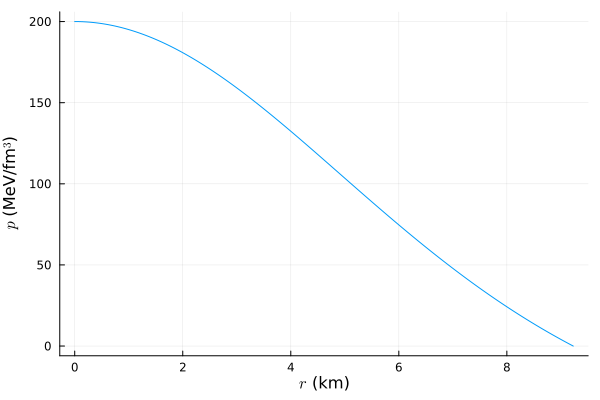

In [16]:
plot(sol[:, 1] .* (lu*1e-3), sol[:, 2] .* pu_to_mevfm3, label=false, 
    xaxis=raw"$r$ (km)", yaxis=raw"$p$ (MeV/fm$^3$)")

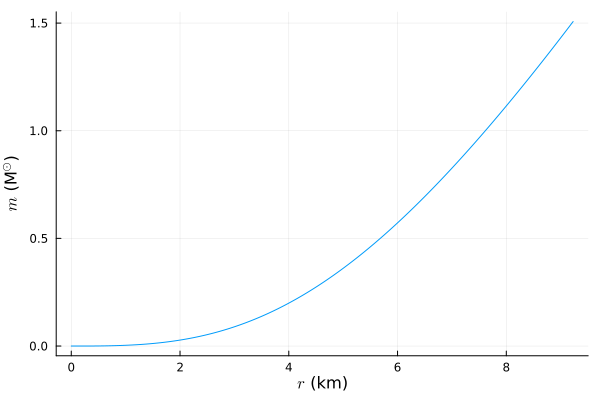

In [17]:
plot(sol[:, 1] .* (lu*1e-3), sol[:, 3], label=false, xaxis=raw"$r$ (km)", 
    yaxis=raw"$m$ (M$^{\odot}$)")

Agora que conseguimos resolver a TOV para uma única estrela com certo $p_0$, vamos por isso em uma função:

In [8]:
function solve_tov(p0)
    pressure_eq(r, p, m) = -(m*eos(p)/r^2)*(1 + p/eos(p))*(1 + 4π*r^3*p/m)*(1 - 2m/r)^(-1)
    mass_eq(r, p, m) = 4π*r^(2)*eos(p)

    f(t, u) = [pressure_eq(t, u[1], u[2]), mass_eq(t, u[1], u[2])]
    condition(t, u, i) = u[1] <= 0 || i > 100_000 ? false : true

    r0 = 1e-8
    m0 = 1e-24

    sol = solve_system(f, r0, [p0, m0], 1m, condition)
    sol[:, 1] = sol[:, 1] .* (lu*1e-3)
    sol[:, 2] = sol[:, 2] .* pu_to_mevfm3
    return sol
end

solve_tov (generic function with 1 method)

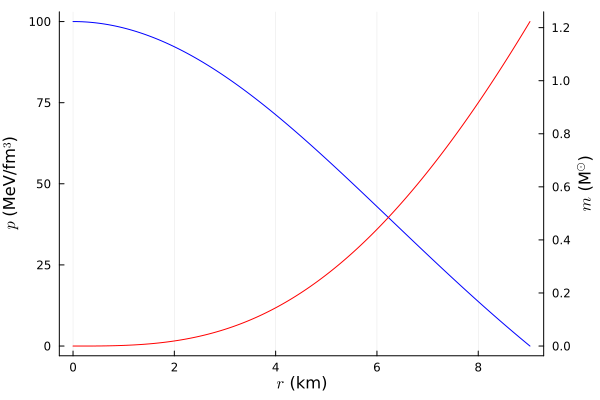

In [19]:
sol = solve_tov(100MeVfm3)
plot(sol[:, 1], sol[:, 2], label=false, xaxis=raw"$r$ (km)", 
    yaxis=raw"$p$ (MeV/fm$^3$)", show=false, color=:blue, linestyle=:solid)
plot!(twinx(), sol[:, 1], sol[:, 3], label=false, yaxis=raw"$m$ (M$^{\odot}$)", 
    color=:red, linesytle=:dash, show=true)

# Resolvendo para uma sequência de estrelas

Resolvemos a TOV para um única estrela usando um único valor de $p_0$, mas podemos resolver essas equações variando $p_0$, a partir retiramos os últimos valores de massa e raio $M$, $R$ e colocamos em uma curva de massa-raio. Para isso é muito útil termos feito a função para resoler a TOV para um único $p_0$.

Vamos começar pegando todos os valores de $p_0$ que iremos utillizar da própria equação de estado, como definimos anteriormente:

In [18]:
pinit = 1e-8
pmax = 700
nstars = 200
p0 = range(pinit, pmax, length=nstars)

1.0e-8:3.5175879396482412:700.0

In [19]:
@time begin

mrdiagram = Matrix(undef, length(p0), 3) 
mrdiagram[:, 1] = p0
mrdiagram[:, 2] = fill(0.0, length(p0))
mrdiagram[:, 3] = fill(0.0, length(p0))

for (i, p_i) in enumerate(p0)
    sol = solve_tov(p_i*MeVfm3)
    mrdiagram[i, 2] = sol[end, 1]
    mrdiagram[i, 3] = sol[end, 3]
end

mrdiagram

end

 31.918176 seconds (282.74 M allocations: 7.084 GiB, 6.14% gc time)


200×3 Matrix{Any}:
   1.0e-8    0.00100001  8.70413e-13
   3.51759   4.618       0.0869964
   7.03518   6.23        0.216653
  10.5528    7.302       0.35362
  14.0704    8.092       0.487591
  17.5879    8.704       0.614479
  21.1055    9.193       0.732802
  24.6231    9.593       0.84246
  28.1407    9.925       0.94357
  31.6583   10.204       1.03664
  35.1759   10.441       1.12233
  38.6935   10.643       1.20097
  42.2111   10.818       1.27373
   ⋮                     
 661.307    10.859       2.27303
 664.824    10.853       2.27219
 668.342    10.847       2.27134
 671.859    10.841       2.27048
 675.377    10.835       2.26962
 678.894    10.829       2.26874
 682.412    10.823       2.26785
 685.93     10.817       2.26695
 689.447    10.811       2.26605
 692.965    10.805       2.26513
 696.482    10.799       2.26421
 700.0      10.793       2.26328

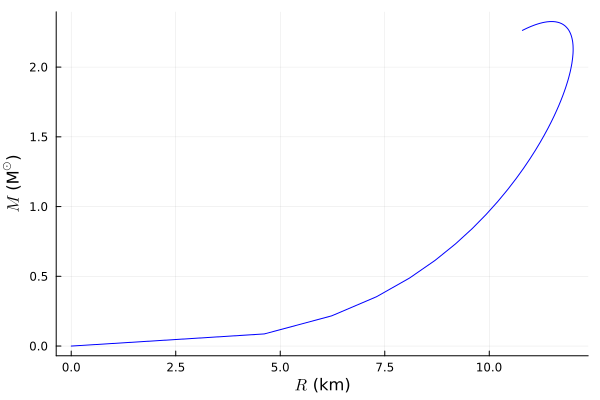

In [17]:
plot(mrdiagram[:, 2], mrdiagram[:, 3], label=false, xaxis=raw"$R$ (km)", 
    yaxis=raw"$M$ (M$^{\odot}$)", show=true, color=:blue, linestyle=:solid)

Podemos já ver um problema com esse código: ele demorou muito para rodar (para $p_0$ ele resolve um sistema de equações diferenciais!). Mas, existe uma maneira de otimizá-lo: se pensarmos um pouco podemos ver que uma solução não depende de outra anterior. O código pode ser paralelizado para usar 100% do processador (ou uma parcela menor).

Para conseguirmos rodar esse código precisaremos reiniciar o kernel do Jupyter para permitir o uso de mais threads.

Abrimos o terminal e entramos no REPL de julia:

```
$ julia

julia> ENV["JULIA_NUM_THREADS"] = 12
julia> using IJulia
julia> notebook()
```

In [6]:
pinit = 1e-8
pmax = 700
nstars = 400
p0 = range(pinit, pmax, length=nstars)

1.0e-8:1.754385964887218:700.0

In [21]:
@time begin
    
mrdiagram = Matrix(undef, length(p0), 3)
mrdiagram[:, 1] = p0
mrdiagram[:, 2] = fill(0.0, length(p0))
mrdiagram[:, 3] = fill(0.0, length(p0)) 

l = ReentrantLock()
Threads.@threads :dynamic for i in 1:length(p0) 
    p_i = p0[i]
    sol = solve_tov(p_i*MeVfm3)

    lock(l)
    try
        mrdiagram[i, 2] = sol[end, 1]
        mrdiagram[i, 3] = sol[end, 3]
    finally
        unlock(l)
    end
end

mrdiagram

end

 81.464913 seconds (455.21 M allocations: 12.027 GiB, 5.04% gc time, 53.61% compilation time)


400×3 Matrix{Any}:
   1.0e-8   0.00100001  1.30199e-12
   1.75439  2.251       0.014942
   3.50877  3.124       0.040185
   5.26316  3.758       0.0703722
   7.01754  4.263       0.103333
   8.77193  4.685       0.137957
  10.5263   5.047       0.173457
  12.2807   5.363       0.209294
  14.0351   5.642       0.245043
  15.7895   5.892       0.280605
  17.5439   6.117       0.315685
  19.2982   6.321       0.35018
  21.0526   6.506       0.383838
   ⋮                    
 680.702    8.487       1.58846
 682.456    8.484       1.58799
 684.211    8.482       1.58781
 685.965    8.48        1.58762
 687.719    8.478       1.58743
 689.474    8.475       1.58696
 691.228    8.473       1.58677
 692.982    8.471       1.58658
 694.737    8.468       1.5861
 696.491    8.466       1.58591
 698.246    8.464       1.58571
 700.0      8.462       1.58551

Mas agora temos um outro problema: as soluções estão todas fora de ordem. Felizmente é algo muito simples de resolver, vamos organizar $p_0$ (junto com os valores de $M$ e $R$) em ordem crescente:

In [11]:
@time begin
    
mrdiagram = Matrix(undef, length(p0), 3)
mrdiagram[:, 1] = p0
mrdiagram[:, 2] = fill(0.0, length(p0))
mrdiagram[:, 3] = fill(0.0, length(p0)) 

l = ReentrantLock()
Threads.@threads :dynamic for i in 1:length(p0) 
    p_i = p0[i]
    sol = solve_tov(p_i*MeVfm3)

    lock(l)
    try
        mrdiagram[i, 2] = sol[end, 1]
        mrdiagram[i, 3] = sol[end, 3]
    finally
        unlock(l)
    end
end

perm = sortperm(mrdiagram[:, 1], alg=QuickSort)
p = mrdiagram[:, 1]
R = mrdiagram[:, 2]
M = mrdiagram[:, 3]
p = p[perm]
R = R[perm]
M = M[perm]
mrdiagram[:, 1] = p
mrdiagram[:, 2] = R
mrdiagram[:, 3] = M

mrdiagram

end

 11.850913 seconds (437.80 M allocations: 10.975 GiB, 21.36% gc time, 4.85% compilation time)


400×3 Matrix{Any}:
   1.0e-8   0.00100001  1.30199e-12
   1.75439  2.251       0.014942
   3.50877  3.124       0.040185
   5.26316  3.758       0.0703722
   7.01754  4.263       0.103333
   8.77193  4.685       0.137957
  10.5263   5.047       0.173457
  12.2807   5.363       0.209294
  14.0351   5.642       0.245043
  15.7895   5.892       0.280605
  17.5439   6.117       0.315685
  19.2982   6.321       0.35018
  21.0526   6.506       0.383838
   ⋮                    
 680.702    8.487       1.58846
 682.456    8.484       1.58799
 684.211    8.482       1.58781
 685.965    8.48        1.58762
 687.719    8.478       1.58743
 689.474    8.475       1.58696
 691.228    8.473       1.58677
 692.982    8.471       1.58658
 694.737    8.468       1.5861
 696.491    8.466       1.58591
 698.246    8.464       1.58571
 700.0      8.462       1.58551

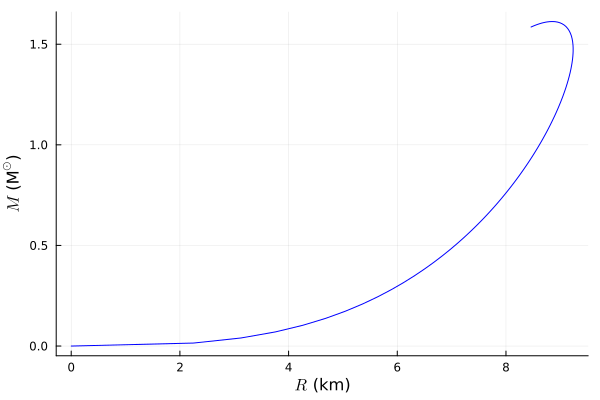

In [10]:
plot(mrdiagram[:, 2], mrdiagram[:, 3], label=false, xaxis=raw"$R$ (km)", 
    yaxis=raw"$M$ (M$^{\odot}$)", show=true, color=:blue, linestyle=:solid)

Ainda temos uma curva meio quadrada e com poucos pontos, mas agora isso pode ser resolvido dividindo $p_0$ de maneiras diferentes (para aumentar a densidade de pontos em uma região do diagrama).